In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")

### 数据预处理

In [2]:
#读取数据库数据
Comment_data = pd.read_csv('data/JDComment_ThinkPadP15v_i7T600.csv')  # 读取训练数据
# Comment_data = pd.read_csv('data/JDComment_HPzhan99_i7T600.csv')  # 读取训练数据

In [3]:
# 把属性名改为英文
Comment_data.rename(columns={'用户ID': 'userId', '评论内容': 'content', '购买时间': 'boughtTime', '点赞数': 'voteCount',
                                '回复数': 'replyCount', '评分': 'score', '评价时间': 'creationTime', '产品型号': 'referenceName'},
                          inplace=True)

In [4]:
Comment_data.isnull().any() #查看是否有缺失值

userId           False
content          False
boughtTime       False
voteCount        False
replyCount       False
score            False
creationTime     False
referenceName    False
dtype: bool

In [6]:
print(len(Comment_data)) #统计评论总数
# 把含有"此用户未及时填写评价内容的评论内容"的评论改为空
Comment_data['content'] = Comment_data['content'].apply(lambda x: "" if x == "此用户未及时填写评价内容" else x)
print(len(Comment_data[Comment_data['content']!=""])) #统计有效评论数

492
489


d:\Statistic apps\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'review score')

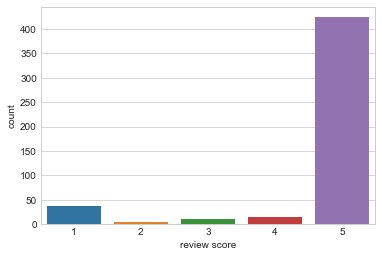

In [7]:
# 查看评分分布情况
Comment_data['score'].value_counts()
# 绘制直方图
sns.countplot(Comment_data.score)
plt.xlabel('review score')

d:\Statistic apps\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'positive'), Text(1, 0, 'neutral'), Text(2, 0, 'negative')]

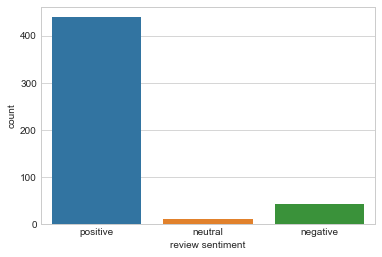

In [8]:
# 查看评分随时间的变化
Comment_data['creationTime'] = pd.to_datetime(Comment_data['creationTime']) #转换为时间格式
# 将4，5算为positive, 1，2算为negative，3算为neutral
Comment_data['Sentiment'] = Comment_data['score'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')

class_names = ['positive', 'neutral', 'negative']
ax = sns.countplot(Comment_data.Sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

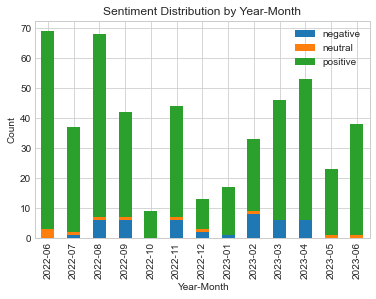

In [15]:
# 绘制不同sentiment数量随时间的变化的堆叠图，以月为groupby单位,每个sentiment
Comment_data['month'] = Comment_data['creationTime'].dt.month
Comment_data['year'] = Comment_data['creationTime'].dt.year
Comment_data['month_year'] = Comment_data['creationTime'].dt.to_period('M')
Comment_data['month_year'] = Comment_data['month_year'].astype(str)
Comment_data['month_year'] = pd.to_datetime(Comment_data['month_year'])
Comment_data['month_year'] = Comment_data['month_year'].dt.strftime('%Y-%m')

# 绘制不同sentiment数量随时间的变化的堆叠图，以月为groupby单位,每个sentiment一种颜色
Comment_data.groupby(['month_year', 'Sentiment']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# 计算neural和negative的比例
print(len(Comment_data[Comment_data['Sentiment'] == 'neutral']) / len(Comment_data))

# 词云图

In [16]:
# 将评论内容中含有"运行速度","屏幕效果","外形外观","散热性能"中间任意一词的评论删除
Comment_data_self = Comment_data[~Comment_data['content'].str.contains("运行速度|屏幕效果|外形外观|散热性能")]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ELEANO~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.606 seconds.
Prefix dict has been built successfully.


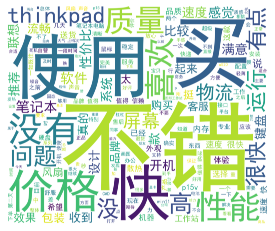

In [17]:
# 绘制词云图
from wordcloud import WordCloud
import jieba

# 读取停用词
stopwords = [line.strip() for line in open('cn_stopwords.txt', encoding='UTF-8').readlines()]
# 添加自定义停用词
stopwords += ['电脑', '非常', '京东', '一直', '一款', '一点', '完全','hellip']

# 读取评论内容
text = ''
for line in Comment_data_self['content']:
    text += ' '.join(jieba.cut(line, cut_all=False))
    # text += ' '.join(line)

# 生成词云
wordcloud = WordCloud(font_path="simhei.ttf", 
                      background_color="white", 
                      width = 1200,
                      height = 1000,
                      stopwords=stopwords,
                      scale=4).generate(text)

# 显示词云图片
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 保存图片
wordcloud.to_file('wordcloud_jieba.png')

In [28]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['STZhongsong']    # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False           # 解决保存图像是负号'-'显示为方块的问题

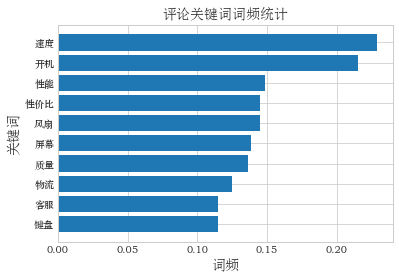

In [47]:
# 对词云图做词频统计，统计出现频率最高的前5个词
import jieba.analyse
# 读取评论内容
text = ''
for line in Comment_data_self['content']:
    text += ' '.join(jieba.cut(line, cut_all=False))

# 去除停用词，包括cn_stopwords.txt和自定义停用词
stopwords = [line.strip() for line in open('cn_stopwords.txt', encoding='UTF-8').readlines()]
stopwords += ['电脑', '非常', '京东', '一直', '一款', '一点', '完全','hellip','笔记本']
# 存储为自定义停用词文件
with open('self_stopwords.txt', 'w', encoding='UTF-8') as file:
    file.write('\n'.join(stopwords))

jieba.analyse.set_stop_words('self_stopwords.txt')

# 提取关键词
keywords = jieba.analyse.extract_tags(text, topK=10, withWeight=True, allowPOS=('n', 'nr', 'ns'))
# 用关键词绘制词频柱状图
# 导入中文字体
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
# 生成数据
reversed_keywords = keywords[::-1]
x = [i[0] for i in reversed_keywords]
y = [i[1] for i in reversed_keywords]
# 绘图
plt.barh(x, y)
plt.title("全部评论关键词词频统计", fontproperties=font)
plt.xlabel("词频", fontproperties=font)
plt.ylabel("关键词", fontproperties=font)
plt.show()


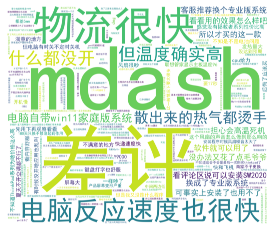

In [19]:
# 提取neural和negative评论作为新的dataframe，绘制词云图
Comment_data_neural = Comment_data_self[Comment_data_self['Sentiment']=="neutral"]
Comment_data_negative = Comment_data_self[Comment_data_self['Sentiment']=="negative"]
Comment_data_nonpos = pd.concat([Comment_data_neural, Comment_data_negative])

data = Comment_data_nonpos['content'].tolist()
dataStr = ','.join(data)

# 生成词云
wordcloud = WordCloud(
        background_color = 'white', #背景颜色，根据图片背景设置，默认为黑色 
        font_path = "simhei.ttf",#若有中文需要设置才会显示中文
        width = 1200,
        height = 1000,
        stopwords=stopwords,
        scale=4,        # 比列放大  数值越大  词云越清晰
        margin = 2).generate(dataStr) # generate 可以对全部文本进行自动分词
#参数 width，height，margin分别对应宽度像素，长度像素，边缘空白处

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# 保存图片
wordcloud.to_file('wordcloud_nonpos.png')



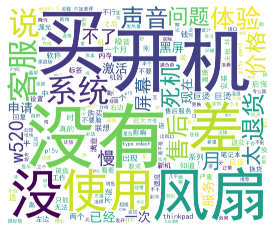

In [20]:
# jieba分词
# 读取停用词
stopwords = [line.strip() for line in open('cn_stopwords.txt', encoding='UTF-8').readlines()]
# 添加自定义停用词
stopwords += ['电脑', '非常', '京东', '一直', '一款', '一点', '完全','hellip']

# 读取评论内容
text = ''
for line in Comment_data_nonpos['content']:
    text += ' '.join(jieba.cut(line, cut_all=False))
    # text += ' '.join(line)

# 生成词云
wordcloud = WordCloud(font_path="simhei.ttf", 
                      background_color="white", 
                      width = 1200,
                      height = 1000,
                      stopwords=stopwords,
                      scale=4).generate(text)

# 显示词云图片
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 保存图片
wordcloud.to_file('wordcloud_nonpos_jieba.png')

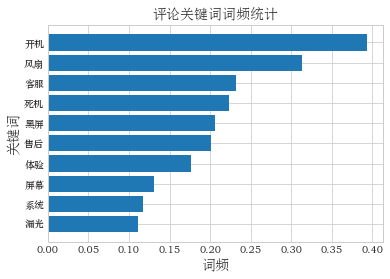

In [48]:
# 对词云图做词频统计，统计出现频率最高的前5个词
import jieba.analyse
# 读取评论内容
text = ''
for line in Comment_data_nonpos['content']:
    text += ' '.join(jieba.cut(line, cut_all=False))

# 去除停用词，包括cn_stopwords.txt和自定义停用词
stopwords = [line.strip() for line in open('cn_stopwords.txt', encoding='UTF-8').readlines()]
stopwords += ['电脑', '非常', '京东', '一直', '一款', '一点', '完全','hellip','笔记本']
# 存储为自定义停用词文件
with open('self_stopwords.txt', 'w', encoding='UTF-8') as file:
    file.write('\n'.join(stopwords))

jieba.analyse.set_stop_words('self_stopwords.txt')

# 提取关键词
keywords = jieba.analyse.extract_tags(text, topK=10, withWeight=True, allowPOS=('n', 'nr', 'ns'))
# 用关键词绘制词频柱状图
# 导入中文字体
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
# 生成数据
reversed_keywords = keywords[::-1]
x = [i[0] for i in reversed_keywords]
y = [i[1] for i in reversed_keywords]
# 绘图
plt.barh(x, y)
plt.title("中差评评论关键词词频统计", fontproperties=font)
plt.xlabel("词频", fontproperties=font)
plt.ylabel("关键词", fontproperties=font)
plt.show()

---

In [38]:
data = Comment_data['content'].tolist()
dataStr = ','.join(data)
#print(','.join(data))

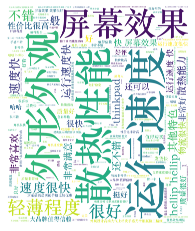

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
 
 
wordcloud = WordCloud(
        background_color = 'white', #背景颜色，根据图片背景设置，默认为黑色
        font_path = "simhei.ttf",#若有中文需要设置才会显示中文
        width = 1000,
        height = 1200,
        scale=4,        # 比列放大  数值越大  词云越清晰
        margin = 2).generate(dataStr) # generate 可以对全部文本进行自动分词
#参数 width，height，margin分别对应宽度像素，长度像素，边缘空白处
 
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
 
# #保存图片：默认为此代码保存的路径
wordcloud.to_file('pics/ThinkPadP15v_i7T600.jpg')
# wordcloud.to_file('pics/HPzhan99_i7T600.jpg')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ELEANO~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.625 seconds.
Prefix dict has been built successfully.


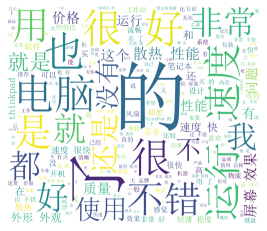

In [11]:
# -*- coding: utf-8 -*-
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import jieba
import os
wordlist = jieba.cut(dataStr, cut_all=False)
word_string = " ".join(wordlist)
wordcloud = WordCloud(font_path='front/simsun.ttc', background_color="white", width=1000, height=860, margin=2,scale=4).generate(word_string)
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud.to_file('pics/ThinkPadP15v_i7T600_分词.jpg')
# wordcloud.to_file('pics/HPzhan99_i7T600_分词.jpg')

去除停用词👇

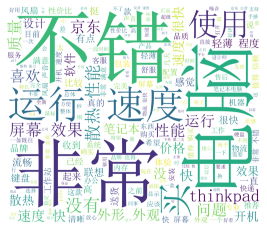

In [13]:
# -*- coding: utf-8 -*-
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import jieba
import os

wordlist = jieba.cut(dataStr, cut_all=False)
stopwords = {}.fromkeys([line.rstrip() for line in open(r'cn_stopwords.txt', encoding='utf-8')])
wordlist = [word for word in wordlist if word not in stopwords]
word_string = " ".join(wordlist)
wordcloud = WordCloud(font_path='front/simsun.ttc', background_color="white", width=1000, height=860, margin=2,scale=4).generate(word_string)
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud.to_file('pics/ThinkPadP15v_i7T600_分词_去除停用词.jpg')
# wordcloud.to_file('pics/HPzhan99_i7T600_分词.jpg')
